### LSTM-RNN Sumatera Selatan Percobaan 2
- Titik Panas diperngaruhi oleh curah hujan

In [1]:
# pustaka untuk manipulasi data
import pandas as pd
from pandas import concat
from pandas import DataFrame
from pandas import read_csv
from pandas import read_excel
import numpy as np
from numpy import concatenate

# pustaka untuk waktu komputasi
import time
from datetime import datetime

# Pustaka untuk visualisasi data
import seaborn as sns # Visualization
from matplotlib import pyplot
from matplotlib import pyplot as plt
        
# Pustaka untuk membuat data latih dan data uji.
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Pustaka untuk membuat model prediksi LSTM-RNN
import itertools
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.optimizers import Adam, Adamax, RMSprop, SGD

# Early stoping
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Pustaka untuk  evaluasi model prediksi
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
# Set waktu komputasi
start = time.time()

In [3]:
# fix random seed for reproducibility
np.random.seed(1234)

In [4]:
# membaca dataset
dataset = read_excel("D:/Belajar-Python/dataset/dataset tesis/dataset.xlsx")

In [5]:
# set index tanggal
dataset = dataset.set_index("tanggal")

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2001-01-31 to 2020-12-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sst             240 non-null    float64
 1   soi             240 non-null    float64
 2   oni             240 non-null    float64
 3   curah_hujan     240 non-null    float64
 4   hotspot_sumsel  240 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 11.2 KB


In [7]:
print(dataset.head())

             sst  soi   oni  curah_hujan  hotspot_sumsel
tanggal                                                 
2001-01-31 -0.76  1.0 -0.68   418.600006               3
2001-02-28 -0.56  1.7 -0.52   295.399994               5
2001-03-31 -0.37  0.9 -0.44   360.600006              10
2001-04-30 -0.56  0.2 -0.34   403.700012              20
2001-05-31 -0.46 -0.5 -0.25   116.900002              39


### Studi Kasus Sumatera Selatan

In [8]:
# memilih area studi
df_sumsel = dataset[["hotspot_sumsel", "curah_hujan"]]
df_sumsel.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2001-01-31 to 2020-12-31
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hotspot_sumsel  240 non-null    int64  
 1   curah_hujan     240 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 5.6 KB


In [9]:
print(df_sumsel.head())

            hotspot_sumsel  curah_hujan
tanggal                                
2001-01-31               3   418.600006
2001-02-28               5   295.399994
2001-03-31              10   360.600006
2001-04-30              20   403.700012
2001-05-31              39   116.900002


In [10]:
# ensure all data is float
values = df_sumsel.values
values = values.astype('float32')

### Normalisasi Data

In [11]:
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

In [12]:
np.round(scaled[:5],6)

array([[-0.999723,  0.549573],
       [-0.999445,  0.082464],
       [-0.998751,  0.329668],
       [-0.997364,  0.493081],
       [-0.994728, -0.594313]], dtype=float32)

### Supervised Learning

In [13]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    # return value
    return agg

In [14]:
# supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [15]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[3]], axis=1, inplace=True)

In [16]:
values = reframed.values

In [17]:
print(reframed.head())

   var1(t-1)  var2(t-1)   var1(t)
1  -0.999723   0.549573 -0.999445
2  -0.999445   0.082464 -0.998751
3  -0.998751   0.329668 -0.997364
4  -0.997364   0.493081 -0.994728
5  -0.994728  -0.594313 -0.999029


### Data latih dan Data Uji

In [18]:
# split into train and test sets
train_size = int(len(values) * 0.8)
test_size = len(values) - train_size
train, test = values[0:train_size,:], values[train_size:len(values),:]

In [19]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [20]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [21]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(191, 1, 2) (191,) (48, 1, 2) (48,)


### Model Prediksi LSTM-RNN

- Kondisi Hyperparameter

In [22]:
# design network grid serach
model = Sequential()

# First LSTM layer with Dropout regularisation
model.add(
    LSTM(
        units=10,
        activation='selu',
        input_shape=(train_X.shape[1], train_X.shape[2])
    )
)
model.add(Dropout(0.2))

# The output layer
model.add(Dense(1))

# model compile
model.compile(
    #optimizer=Adamax(learning_rate=0.001, decay=0.000001),
    optimizer='adamax',
    loss='mae',
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)

# fit network
history = model.fit(train_X, train_y, epochs=2000, batch_size=8,
                    validation_data=(test_X, test_y),
                    verbose=0, shuffle=False)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                520       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________


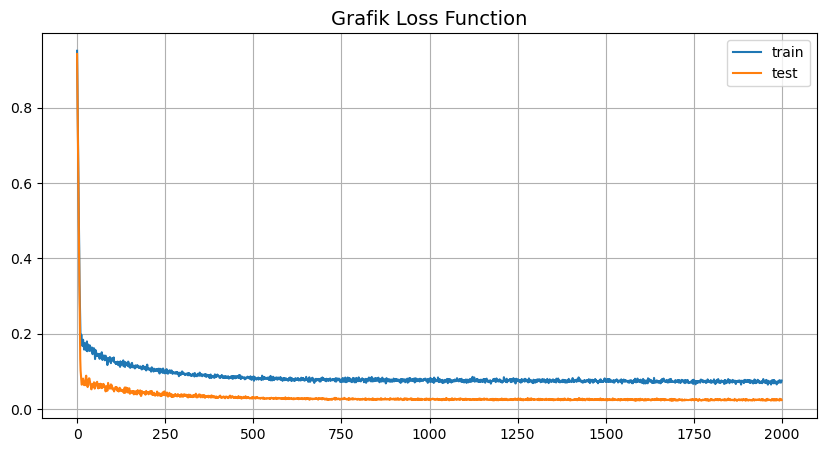

In [24]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(history.history['loss'], color="tab:blue", label="train", linewidth=1.5)
ax.plot(history.history['val_loss'], color="tab:orange", label="test", linewidth=1.5)

# membuat label-label
ax.set_title("Grafik Loss Function", fontsize=14)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

In [25]:
# 5. make predictions
predictions = model.predict(test_X, verbose=0)
print(predictions[:, 0])

[-0.9892489  -0.99622643 -0.99638814 -0.99608    -0.99626416 -0.9892395
 -0.96070886 -0.9494517  -0.95251465 -0.98147523 -0.9950227  -0.99644154
 -0.9962002  -0.9879941  -0.9962519  -0.9964892  -0.9959807  -0.9886086
 -0.97063804 -0.9943996  -0.9376524  -0.9780487  -0.97053    -0.9959709
 -0.99614537 -0.996163   -0.99643683 -0.9960992  -0.99621075 -0.9671776
 -0.96604276 -0.94220257 -0.7534879  -0.5385884  -0.52607834 -0.80709624
 -0.9962199  -0.9954285  -0.9886915  -0.9956233  -0.9955748  -0.9904407
 -0.9869622  -0.9872424  -0.95385265 -0.9906667  -0.9960008  -0.99446744]


### Evaluasi Model LSTM-RNN

In [26]:
scores = model.evaluate(train_X, train_y)
scores

6/6 [==============================] - 0s 2ms/step - loss: 0.0711 - mean_absolute_error: 0.0711 - mean_squared_error: 0.0362 - root_mean_squared_error: 0.1902


[0.07114096730947495,
 0.07114096730947495,
 0.03618096560239792,
 0.19021295011043549]

In [27]:
scores = model.evaluate(test_X, test_y)
scores

2/2 [==============================] - 0s 5ms/step - loss: 0.0248 - mean_absolute_error: 0.0248 - mean_squared_error: 0.0041 - root_mean_squared_error: 0.0640


[0.02481582760810852,
 0.02481582760810852,
 0.004095885436981916,
 0.06399910151958466]

- MAE

In [28]:
mae = mean_absolute_error(test_y, predictions)
print('Test MAE: %.4f' % mae)

Test MAE: 0.0248


- MSE

In [29]:
mse = mean_squared_error(test_y, predictions)
print('Test MSE: %.4f' % mse)

Test MSE: 0.0041


- RMSE

In [30]:
# calculate RMSE
rmse = sqrt(mean_squared_error(test_y , predictions))
print('Test RMSE: %.4f' % rmse)

Test RMSE: 0.0640


- korelasi dan signifikansi

In [31]:
hasil = np.stack((test_y.reshape(-1),predictions.reshape(-1)),axis=1)
hasil = pd.DataFrame(hasil, columns = ['data_aktual','prediksi'])
hasil.head()

,data_aktual,prediksi
0,-0.998474,-0.989249
1,-0.999723,-0.996226
2,-0.997503,-0.996388
3,-0.997364,-0.996080
4,-0.994450,-0.996264


In [32]:
import scipy.stats as sc
r, p = sc.pearsonr(hasil["data_aktual"], hasil["prediksi"])
print("korelasi data akual dengan hasil prediksi" +" {:.4f} ".format(r)+ "dengan signifikansi" +" {:.4f} ".format(p))

korelasi data akual dengan hasil prediksi 0.8247 dengan signifikansi 0.0000 


- Waktu komputasi

In [33]:
# Set akhir waktu komputasi 
end = time.time()

In [34]:
# Proses menghitung waktu komputasi
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)

In [35]:
# Hasil waktu komputasi
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:02:20.74


### Visualisasi hasil prediksi

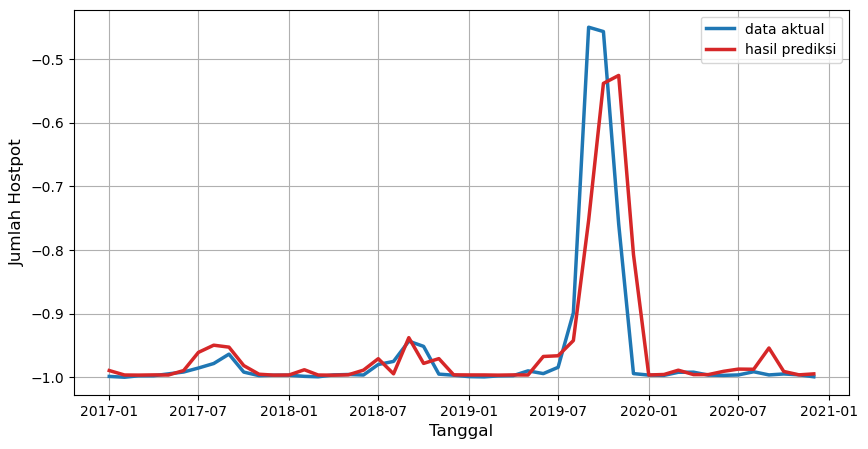

In [36]:
# generate urutan data sesuai panjang datanya
x = pd.date_range(start="2017-01-01", periods=len(test_y), freq='MS')

# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(x, test_y, color="tab:blue", label="data aktual", linewidth=2.5)
ax.plot(x, predictions, color="tab:red", label="hasil prediksi", linewidth=2.5)

# membuat label-label
# ax.set_title("Hotspot Sumsel Sensor MODIS 2018-2020", fontsize=14)
ax.set_xlabel("Tanggal", fontsize=12)
ax.set_ylabel("Jumlah Hostpot", fontsize=12)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()